## Ergast Formula 1 Database

Ноутбук, посвященный гонкам Формулы-1. 

Основная его цель:
 - просто вспомнить SQL;
 - вспомнить оконные функции;
 - вспомнить, как подключаться к локальной базе;
 - вспомнить, как визуализировать "сухие" таблицы SQL средствами python.

### Загрузка библиотек


In [1]:
import pymysql
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

C:\Temp\ipykernel_8440\3621018836.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Решение проблем с подключением локальной базы к VSCode

Подключаемся к локальной базе. Работаем через VSCode. В процессе фиксим ошибку *ER_NOT_SUPPORTED_AUTH_MODE Client*.

#### Windows

- Вызываем cmd в папке bin MySQL (C:\Program Files\MySQL\MySQL Server 8.3\bin) 
- CREATE USER '**sqluser**'@'%' IDENTIFIED WITH mysql_native_password BY '**password**'; 
- GRANT ALL PRIVILEGES ON *.* TO 'sqluser'@'%'; 
- FLUSH PRIVILEGES;

#### Linux

- sudo mysql -u root -p
- ALTER USER "root"@"localhost" identified with mysql_native_password by "pass";

### Подключение к локальной базе

In [2]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="rt",
                       password="-",
                       database="sys",
                       charset="utf8")


sql = """
SELECT * 
  FROM circuits;
"""

df = pd.read_sql(sql, conn)
df.head(5)

C:\Temp\ipykernel_8440\3983184444.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


Вроде работает. 

### Работа с запросами

*1. Вывести количество треков по странам*

In [3]:
sql1 = """
SELECT country, COUNT(location) AS 'Количество'   
  FROM circuits
 GROUP by country
 ORDER BY 2 DESC;
 """

df = pd.read_sql(sql1, conn)
df.head(10)

C:\Temp\ipykernel_8440\1506444159.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql1, conn)


,country,Количество
0,USA,11
1,France,7
2,Spain,6
3,Italy,4
4,Portugal,4
5,UK,4
6,Japan,3
7,Belgium,3
8,Canada,3
9,Germany,3


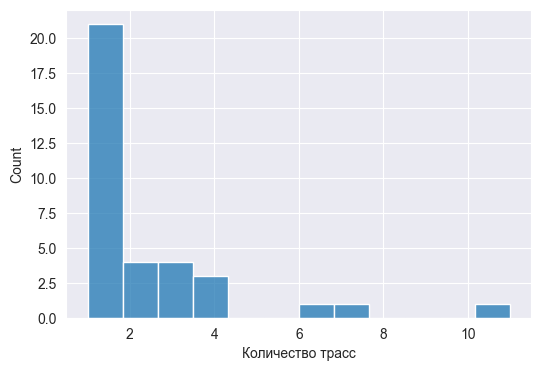

In [4]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(6,4))
x = df['Количество']
x = pd.Series(x, name="Количество трасс")
ax = sns.histplot(x, bins=12)
plt.show()

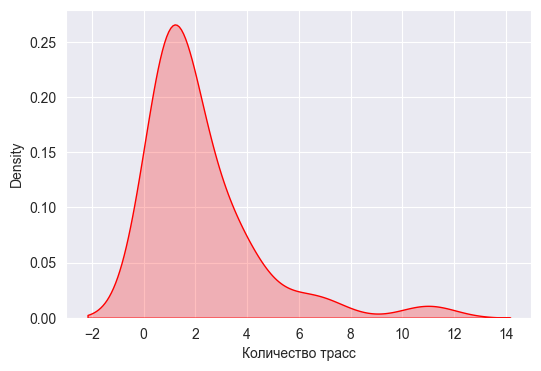

In [5]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(6,4))
x = df['Количество']
x = pd.Series(x, name="Количество трасс")
ax = sns.kdeplot(x, fill= True, color='r')
plt.show()

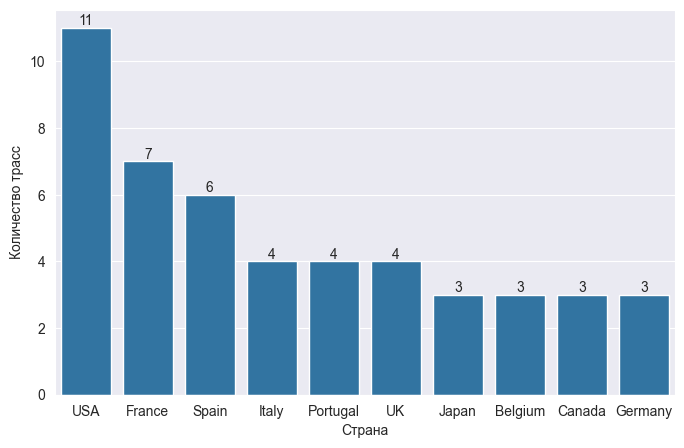

In [6]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(8,5))
ax = sns.barplot(data=df, x=df.country[:10], y="Количество")
ax.set_xlabel('Страна', fontdict={'size': 10})
ax.set_ylabel('Количество трасс', fontdict={'size': 10})
ax.bar_label(ax.containers[0])
# for i in ax.containers:
#     ax.bar_label(i,)
plt.show()

*2. Вывести кубок конструкторов за 20-23 годы. Сортировка по убыванию.*

In [7]:
sql2 = """
SELECT con.name AS "Команда", 
       SUM(rc.points) AS "Очки", 
       r.year 
  FROM results rc
       INNER JOIN constructors con USING (constructorId)
             JOIN races r USING (raceId)
 WHERE r.YEAR >= 2018
 GROUP BY 1,3
 ORDER BY 3, 2 DESC;
"""

df2 = pd.read_sql(sql2, conn)
df2.head(10)

C:\Temp\ipykernel_8440\4290888719.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(sql2, conn)


,Команда,Очки,year
0,Mercedes,655.0,2018
1,Ferrari,571.0,2018
2,Red Bull,419.0,2018
3,Renault,122.0,2018
4,Force India,111.0,2018
5,Haas F1 Team,93.0,2018
6,McLaren,62.0,2018
7,Sauber,48.0,2018
8,Toro Rosso,33.0,2018
9,Williams,7.0,2018


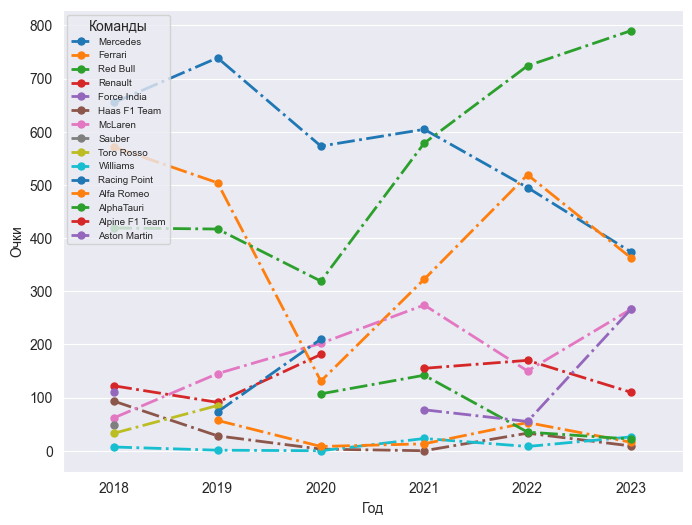

In [8]:
f, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(x="year",
              y="Очки", 
              linestyles = '-.',
              linewidth = 2,
              markeredgewidth=1,
              hue="Команда",
              data=df2,
              palette="tab10")
ax.set_xlabel('Год', fontdict={'size': 10})
ax.set_ylabel('Очки', fontdict={'size': 10})
plt.legend(title = 'Команды', fontsize="7", loc ="upper left")
plt.show()

*3. Вывести гонщиков с наибольшим количеством побед. Сортировка по убыванию. Вывод ограничить 20 пилотами*

In [9]:
sql3 = """
SELECT CONCAT(d.forename,' ',d.surname) AS "Pilot", COUNT(r.YEAR) AS "Количество побед"
  FROM results rc
   		INNER JOIN drivers d USING (driverId)
   		      JOIN races r USING (raceId)
 WHERE r.YEAR >= 1950 AND rc.position = 1
 GROUP BY 1
 ORDER BY 2 DESC
 LIMIT 20;
"""

df3 = pd.read_sql(sql3, conn)
df3.head(10)

C:\Temp\ipykernel_8440\2143894786.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql(sql3, conn)


,Pilot,Количество побед
0,Lewis Hamilton,103
1,Michael Schumacher,91
2,Max Verstappen,54
3,Sebastian Vettel,53
4,Alain Prost,51
5,Ayrton Senna,41
6,Fernando Alonso,32
7,Nigel Mansell,31
8,Jackie Stewart,27
9,Jim Clark,25


C:\Temp\ipykernel_8440\2445483531.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


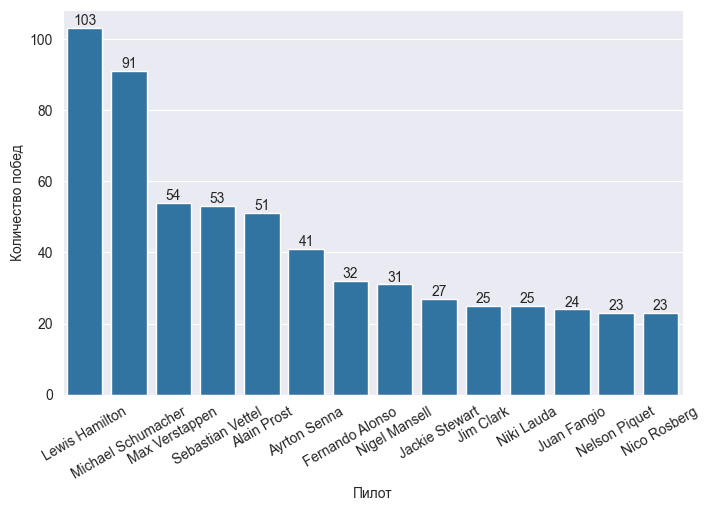

In [49]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(8,5))
ax = sns.barplot(data=df3,
                 x=df3.Pilot[:14],
                 y="Количество побед")
ax.set_xlabel('Пилот', fontdict={'size': 10})
ax.set_ylabel('Количество побед', fontdict={'size': 10})
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.bar_label(ax.containers[0])
# for i in ax.containers:
#     ax.bar_label(i,)
plt.show()

*4. Вывести гонщиков Ferrari, выступавших за конюшню с 1996 по 2023 годы, и посчитать их набранные очки. Присвоить им ранг.*

In [12]:
sql4 = """
SELECT DENSE_RANK() OVER (ORDER BY SUM(r.points) DESC) AS 'Rank',
	   CONCAT(d.forename,' ',d.surname) AS 'Пилот',
  	   SUM(r.points) AS 'Очки'
  FROM drivers d
       INNER JOIN results r USING (driverId)
       	     JOIN constructors cons USING (constructorId)
       	     JOIN races USING (raceId)
 WHERE cons.name = 'Ferrari' 
   AND races.YEAR >= 1996 
   AND races.YEAR < 2024
 GROUP BY 2
 ORDER BY 1;
"""

df4 = pd.read_sql(sql4, conn)
df4.head(10)

C:\Temp\ipykernel_8440\2963395708.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df4 = pd.read_sql(sql4, conn)


,Rank,Пилот,Очки
0,1,Sebastian Vettel,1400.0
1,2,Fernando Alonso,1190.0
2,3,Kimi Räikkönen,1080.0
3,4,Michael Schumacher,1066.0
4,5,Charles Leclerc,997.0
5,6,Felipe Massa,789.0
6,7,Carlos Sainz,569.5
7,8,Rubens Barrichello,412.0
8,9,Eddie Irvine,156.0
9,10,Mika Salo,10.0


*5.Вывести гонщиков Mclaren, выступавших за конюшню с 1990 по 2023 годы, и посчитать их победы и набранные очки за эту команду.*

In [13]:
sql5 = """
WITH cte AS(   
SELECT CONCAT(d.forename,' ', d.surname) AS "Пилот",
       driverid,
       SUM(res.position) AS "Победы"
  FROM results res
       INNER JOIN drivers d USING (driverId)
			 JOIN constructors cons USING (constructorId)
			 JOIN races USING (raceId)
 WHERE cons.name = 'McLaren'
   AND races.YEAR >= 1990
   AND races.YEAR < 2024
   AND res.position = '1'
 GROUP BY 1,2
 )
          
 SELECT Пилот,
        Победы,
        SUM(results.points) AS "Очки"
   FROM cte
        INNER JOIN results USING (driverId)
              JOIN constructors cons USING (constructorId)
  WHERE cons.name = 'McLaren'
  GROUP BY 1,2
  ORDER BY 3 DESC;
  """

df5 = pd.read_sql(sql5, conn)
df5.head(10)

C:\Temp\ipykernel_8440\1702859064.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df5 = pd.read_sql(sql5, conn)


,Пилот,Победы,Очки
0,Lewis Hamilton,21.0,913.0
1,Jenson Button,8.0,908.0
2,Ayrton Senna,21.0,451.0
3,David Coulthard,12.0,412.0
4,Mika Häkkinen,20.0,407.0
5,Kimi Räikkönen,9.0,337.0
6,Fernando Alonso,4.0,241.0
7,Daniel Ricciardo,1.0,148.0
8,Gerhard Berger,3.0,135.0
9,Juan Pablo Montoya,3.0,86.0


*6.Вывести 15 лучших кругов на СПА. Присвоить ранги. (res rank)*

In [14]:
sql6 = """
SELECT DENSE_RANK() OVER (ORDER BY milliseconds ASC) AS 'Rank',
       r.YEAR AS 'Год',
 	   c.name AS 'Трасса', 
 	   time_format(SEC_TO_TIME(milliseconds/1000), '%i:%s:%f') AS 'Время круга, в мс'
  FROM lapTimes l
	   INNER JOIN races r USING (raceId)
             JOIN circuits c USING (circuitId)
 WHERE c.name = 'Circuit de Spa-Francorchamps'
   AND milliseconds IN (
                        SELECT min(milliseconds)
                          FROM lapTimes l2
                               INNER JOIN races r2 USING (raceId)
                                     JOIN circuits c2 USING (circuitId)
                         WHERE c2.name = 'Circuit de Spa-Francorchamps'
                         GROUP BY r2.YEAR, r2.raceId, c2.name
                         )
 LIMIT 15;
 """

df6 = pd.read_sql(sql6, conn)
df6.head(15)

C:\Temp\ipykernel_8440\2435548389.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df6 = pd.read_sql(sql6, conn)


,Rank,Год,Трасса,"Время круга, в мс"
0,1,2004,Circuit de Spa-Francorchamps,01:45:108000
1,2,2018,Circuit de Spa-Francorchamps,01:46:286000
2,3,2019,Circuit de Spa-Francorchamps,01:46:409000
3,4,2017,Circuit de Spa-Francorchamps,01:46:577000
4,5,2002,Circuit de Spa-Francorchamps,01:47:176000
5,6,2009,Circuit de Spa-Francorchamps,01:47:263000
6,7,2023,Circuit de Spa-Francorchamps,01:47:305000
7,8,2020,Circuit de Spa-Francorchamps,01:47:483000
8,9,2008,Circuit de Spa-Francorchamps,01:47:930000
9,10,2007,Circuit de Spa-Francorchamps,01:48:036000


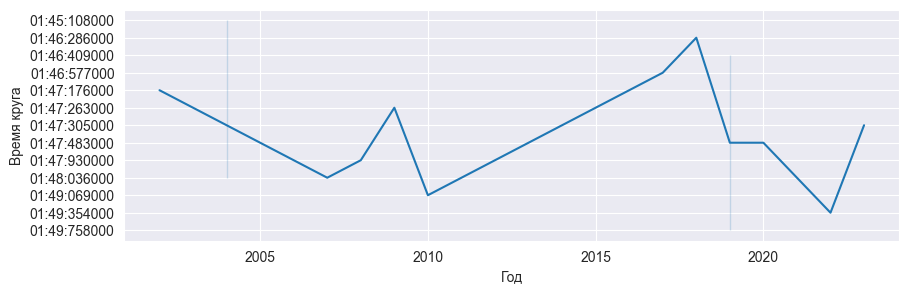

In [76]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,3))
ax = sns.lineplot(x=df6["Год"],
                  y=df6["Время круга, в мс"],
                  data=df6
                  )
ax.set_xlabel('Год', fontdict={'size': 10})
ax.set_ylabel('Время круга', fontdict={'size': 10})
plt.show()

*6.1. Вывести 15 лучших кругов Имолы по годам.*

In [15]:
sql7 = """
SELECT DISTINCT r2.YEAR,
                c2.name,
                MIN(time_format(SEC_TO_TIME(milliseconds/1000), '%i:%s:%f')) OVER (PARTITION BY r2.YEAR) AS 'Время, в мс'
  FROM laptimes l2
       INNER JOIN races r2 USING (raceId)
             JOIN circuits c2 USING (circuitId)
  WHERE c2.name = 'Autodromo Enzo e Dino Ferrari'
ORDER BY 3 ASC
LIMIT 15;
"""

df7 = pd.read_sql(sql7, conn)
df7.head(15)

C:\Temp\ipykernel_8440\1300942658.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df7 = pd.read_sql(sql7, conn)


,YEAR,name,"Время, в мс"
0,2020,Autodromo Enzo e Dino Ferrari,01:15:484000
1,2021,Autodromo Enzo e Dino Ferrari,01:16:702000
2,2022,Autodromo Enzo e Dino Ferrari,01:18:446000
3,2004,Autodromo Enzo e Dino Ferrari,01:20:411000
4,2005,Autodromo Enzo e Dino Ferrari,01:21:858000
5,2003,Autodromo Enzo e Dino Ferrari,01:22:491000
6,2002,Autodromo Enzo e Dino Ferrari,01:24:170000
7,2006,Autodromo Enzo e Dino Ferrari,01:24:569000
8,2001,Autodromo Enzo e Dino Ferrari,01:25:524000
9,1997,Autodromo Enzo e Dino Ferrari,01:25:531000


*7. Вывести трассы, на которых побеждал Хэмилтон. Добавить столбец накопленного итога*

In [79]:
sql8="""
WITH cte AS( 
SELECT c2.name,
       SUM(res.position) AS "Победы"        
  FROM results res
       INNER JOIN drivers d USING (driverId)
			 JOIN constructors cons USING (constructorId)
			 JOIN races r2 USING (raceId)
			 JOIN circuits c2 USING (circuitId)
 WHERE d.surname = 'Hamilton'
   AND d.forename = 'Lewis'
   AND res.position = '1'
 GROUP BY 1
)

SELECT c3.name AS "Трасса", 
       Победы,
       SUM(Победы) OVER (ORDER BY c3.name) AS "Накопленный итог"
  FROM cte
       INNER JOIN circuits c3 ON cte.name = c3.name;
"""

df8 = pd.read_sql(sql8, conn)
df8.head(60)

C:\Temp\ipykernel_8440\3723132162.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df8 = pd.read_sql(sql8, conn)


,Трасса,Победы,Накопленный итог
0,Albert Park Grand Prix Circuit,2.0,2.0
1,Autodromo Enzo e Dino Ferrari,1.0,3.0
2,Autódromo Hermanos Rodríguez,2.0,5.0
3,Autódromo Internacional do Algarve,2.0,7.0
4,Autodromo Internazionale del Mugello,1.0,8.0
5,Autódromo José Carlos Pace,3.0,11.0
6,Autodromo Nazionale di Monza,5.0,16.0
7,Bahrain International Circuit,5.0,21.0
8,Baku City Circuit,1.0,22.0
9,Circuit de Barcelona-Catalunya,6.0,28.0


*8. ТОП-10 трасс, на которых Ferrari набрала больше всего очков с 1996 по 2024*

In [21]:
sql9 = """
SELECT c2.name AS "Трасса",
       SUM(res.points) AS "Очки"        
  FROM results res
       INNER JOIN drivers d USING (driverId)
			 JOIN constructors cons USING (constructorId)
			 JOIN races r2 USING (raceId)
			 JOIN circuits c2 USING (circuitId)
 WHERE cons.name = 'Ferrari'
 GROUP BY 1 
 ORDER BY 2 DESC 
 LIMIT 10;
 """
df9 = pd.read_sql(sql9, conn)
df9.head(10)

C:\Temp\ipykernel_8440\2322443285.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df9 = pd.read_sql(sql9, conn)


,Трасса,Очки
0,Autodromo Nazionale di Monza,771.50
1,Circuit de Monaco,594.50
2,Silverstone Circuit,572.78
3,Circuit de Spa-Francorchamps,499.50
4,Circuit Gilles Villeneuve,466.00
5,Autódromo José Carlos Pace,442.00
6,Hungaroring,442.00
7,Circuit de Barcelona-Catalunya,413.00
8,Albert Park Grand Prix Circuit,366.00
9,Red Bull Ring,360.50


*9. Позиции команд в КК*

In [83]:
 sql10 = """
 SELECT DENSE_RANK() OVER (PARTITION BY r.YEAR ORDER BY SUM(points) DESC) AS "R",
	    con.name,
	    r.YEAR       
   FROM results rc
	    INNER JOIN constructors con USING (constructorId)
	          JOIN races r USING (raceId)
  WHERE YEAR >= 2018
	AND YEAR <= 2023
  GROUP BY 2,3;
"""

df10 = pd.read_sql(sql10, conn)
df10.head(20)

C:\Temp\ipykernel_8440\2152727337.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df10 = pd.read_sql(sql10, conn)


,R,name,YEAR
0,1,Mercedes,2018
1,2,Ferrari,2018
2,3,Red Bull,2018
3,4,Renault,2018
4,5,Force India,2018
5,6,Haas F1 Team,2018
6,7,McLaren,2018
7,8,Sauber,2018
8,9,Toro Rosso,2018
9,10,Williams,2018


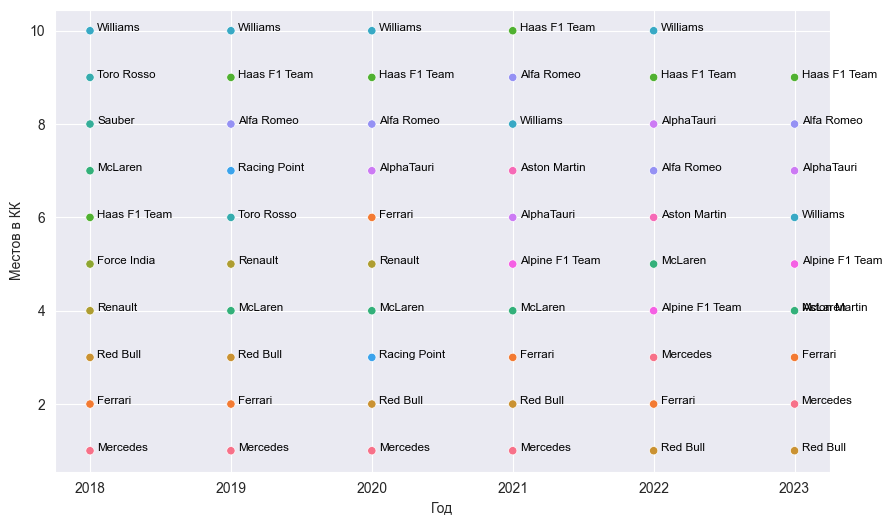

In [124]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,6))
ax = sns.scatterplot(x=df10["YEAR"],
                  y=df10["R"],
                  hue = df10["name"],
                  data = df10,
                  legend = False)

for line in range(0,df10.shape[0]):
     ax.text(df10.YEAR[line]+0.05, df10.R[line], 
     df10.name[line], horizontalalignment='left', 
     size='small', color='black')
ax.set_xlabel('Год', fontdict={'size': 10})
ax.set_ylabel('Местов в КК', fontdict={'size': 10})
plt.show()

*10. Сравнить выступления Ferrari с 2000 по 2023 годы (сравниваем очки)*

In [25]:
sql11 = """
WITH prev AS(
SELECT con2.name AS "con_prev",
	   r2.YEAR AS "year_prev",
	   SUM(rc.points) AS "prev_pts",
	   LAG(SUM(rc.points), 1) OVER (ORDER BY YEAR) AS "prev"
  FROM results rc
	    INNER JOIN constructors con2 USING (constructorId)
	          JOIN races r2 USING (raceId)
  WHERE YEAR >= 2010
	AND YEAR <= 2023
	AND con2.name = 'Ferrari'
  GROUP BY 1,2
)
	 
SELECT con_prev AS "Команда",
       year_prev,
	   prev_pts,
	   round((prev_pts - prev)*100/ prev, 2) as "diff"
  FROM prev;
  """

df11 = pd.read_sql(sql11, conn)
df11.head(20)

C:\Temp\ipykernel_8440\2385171808.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df11 = pd.read_sql(sql11, conn)


,Команда,year_prev,prev_pts,diff
0,Ferrari,2010,396.0,NaN
1,Ferrari,2011,375.0,-5.30
2,Ferrari,2012,400.0,6.67
3,Ferrari,2013,354.0,-11.50
4,Ferrari,2014,216.0,-38.98
5,Ferrari,2015,428.0,98.15
6,Ferrari,2016,398.0,-7.01
7,Ferrari,2017,522.0,31.16
8,Ferrari,2018,571.0,9.39
9,Ferrari,2019,504.0,-11.73


*11. Соотнести по командам гонщиков по их количеству побед (ранжировать их в рамках команды)*

In [27]:
sql12 = """
WITH cte AS(   
SELECT CONCAT(d.forename,' ', d.surname) AS "Пилот",
       cons.name AS "Команда",
       driverId,
       SUM(res.position) AS "Победы"
  FROM results res
       INNER JOIN drivers d USING (driverId)
			 JOIN constructors cons USING (constructorId)
			 JOIN races USING (raceId)
 WHERE races.YEAR >= 1980 
   AND races.YEAR < 2024
   AND res.position = '1'
 GROUP BY 2,1,3
 )
 
 SELECT DENSE_RANK() OVER (PARTITION BY Команда ORDER BY Победы DESC) AS "R",
 		Пилот,
 		Команда,
        Победы,
        max(Победы) over (partition by Команда) as max,
        min(Победы) over (partition by Команда) as min
   FROM cte
  ORDER BY 3, 4 DESC;
"""

df12 = pd.read_sql(sql12, conn)
df12.head(20)

C:\Temp\ipykernel_8440\888340241.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df12 = pd.read_sql(sql12, conn)


,R,Пилот,Команда,Победы,max,min
0,1,Pierre Gasly,AlphaTauri,1.0,1.0,1.0
1,1,Esteban Ocon,Alpine F1 Team,1.0,1.0,1.0
2,1,Michael Schumacher,Benetton,19.0,19.0,1.0
3,2,Nelson Piquet,Benetton,3.0,19.0,1.0
4,3,Johnny Herbert,Benetton,2.0,19.0,1.0
5,3,Gerhard Berger,Benetton,2.0,19.0,1.0
6,4,Alessandro Nannini,Benetton,1.0,19.0,1.0
7,1,Robert Kubica,BMW Sauber,1.0,1.0,1.0
8,1,Nelson Piquet,Brabham,13.0,13.0,2.0
9,2,Riccardo Patrese,Brabham,2.0,13.0,2.0


*12. Какой процент от всех побед конюшни внес гонщик*

In [28]:
sql13 = """
WITH cte AS(   
SELECT CONCAT(d.forename,' ', d.surname) AS "Пилот",
       cons.name AS "Команда",
       driverId,
       SUM(res.position) AS "Победы"
  FROM results res
       INNER JOIN drivers d USING (driverId)
			 JOIN constructors cons USING (constructorId)
			 JOIN races USING (raceId)
 WHERE races.YEAR >= 1980 
   AND races.YEAR < 2024
   AND res.position = '1'
 GROUP BY 2,1,3
 )
 
 SELECT Пилот,
 		Команда,
        Победы,
        SUM(Победы) OVER (PARTITION BY Команда) as "Общее число побед",
        ROUND(Победы * 100.0 / SUM(Победы) OVER (PARTITION BY Команда),2) as "Процент побед"
   FROM cte
  ORDER BY 2, 3 DESC; 
  """

df13 = pd.read_sql(sql13, conn)
df13.head(20)

C:\Temp\ipykernel_8440\1774103940.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df13 = pd.read_sql(sql13, conn)


,Пилот,Команда,Победы,Общее число побед,Процент побед
0,Pierre Gasly,AlphaTauri,1.0,1.0,100.00
1,Esteban Ocon,Alpine F1 Team,1.0,1.0,100.00
2,Michael Schumacher,Benetton,19.0,27.0,70.37
3,Nelson Piquet,Benetton,3.0,27.0,11.11
4,Johnny Herbert,Benetton,2.0,27.0,7.41
5,Gerhard Berger,Benetton,2.0,27.0,7.41
6,Alessandro Nannini,Benetton,1.0,27.0,3.70
7,Robert Kubica,BMW Sauber,1.0,1.0,100.00
8,Nelson Piquet,Brabham,13.0,15.0,86.67
9,Riccardo Patrese,Brabham,2.0,15.0,13.33


*13. На какой трассе какая команда чаще всего побеждала. Вывести команды и их победы, процент побед. Ранжировать.*

In [29]:
sql14 = """
WITH cte AS(
SELECT c2.name AS "Трасса",
	   cons.name AS "Команда",	
	   SUM(res.position) AS "Победы"
  FROM results res
	   INNER JOIN drivers d USING (driverId)
		     JOIN constructors cons USING (constructorId)
			 JOIN races USING (raceId)
			 JOIN circuits c2 USING (circuitId)
 WHERE races.YEAR >= 1980 
   AND races.YEAR < 2024
   AND res.position = '1'
 GROUP BY 1,2
)

SELECT DENSE_RANK() OVER (PARTITION BY Трасса ORDER BY Победы DESC) AS "R",
       Трасса,
 	   Команда,
       Победы,
       SUM(Победы) OVER (PARTITION BY Трасса) as "Общее число побед",
       ROUND(Победы * 100.0 / SUM(Победы) OVER (PARTITION BY Трасса),2) as "Процент побед"
  FROM cte
 ORDER BY 2,4 DESC; 
 """

df14 = pd.read_sql(sql14, conn)
df14.head(20)

C:\Temp\ipykernel_8440\2739432435.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df14 = pd.read_sql(sql14, conn)


,R,Трасса,Команда,Победы,Общее число побед,Процент побед
0,1,Adelaide Street Circuit,McLaren,5.0,11.0,45.45
1,2,Adelaide Street Circuit,Williams,4.0,11.0,36.36
2,3,Adelaide Street Circuit,Benetton,1.0,11.0,9.09
3,3,Adelaide Street Circuit,Ferrari,1.0,11.0,9.09
4,1,Albert Park Grand Prix Circuit,Ferrari,9.0,26.0,34.62
5,2,Albert Park Grand Prix Circuit,McLaren,6.0,26.0,23.08
6,3,Albert Park Grand Prix Circuit,Mercedes,4.0,26.0,15.38
7,4,Albert Park Grand Prix Circuit,Renault,2.0,26.0,7.69
8,4,Albert Park Grand Prix Circuit,Red Bull,2.0,26.0,7.69
9,5,Albert Park Grand Prix Circuit,Williams,1.0,26.0,3.85


*14. Подсчитать количество очков каждого пилота. Вывести сумму очков команды в КК. Указать долю каждого пилота в сумме. Взять 2022 год.*

In [30]:
sql15 = """
WITH cte AS(   
SELECT CONCAT(d.forename,' ', d.surname) AS "Пилот",
       cons.name AS "Команда",
       SUM(res.points) AS "Очки"
  FROM results res
       INNER JOIN drivers d USING (driverId)
			 JOIN constructors cons USING (constructorId)
			 JOIN races USING (raceId)
 WHERE races.YEAR > 2021 
   AND races.YEAR < 2023
 GROUP BY 1,2
 ORDER BY 2
 )
          
 SELECT Команда,
        Пилот,
        Очки,
        ROUND(Очки * 100.0 / SUM(Очки) OVER (PARTITION BY Команда),2) as "%,очков",
        SUM(Очки) OVER (PARTITION BY Команда) as "Очки КК"
   FROM cte
  ORDER BY 5 DESC; 
 """

df15 = pd.read_sql(sql15, conn)
df15.head(20)

C:\Temp\ipykernel_8440\2419346407.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df15 = pd.read_sql(sql15, conn)


,Команда,Пилот,Очки,"%,очков",Очки КК
0,Red Bull,Sergio Pérez,291.0,40.19,724.0
1,Red Bull,Max Verstappen,433.0,59.81,724.0
2,Ferrari,Charles Leclerc,291.0,56.07,519.0
3,Ferrari,Carlos Sainz,228.0,43.93,519.0
4,Mercedes,Lewis Hamilton,233.0,47.07,495.0
5,Mercedes,George Russell,262.0,52.93,495.0
6,Alpine F1 Team,Esteban Ocon,89.0,52.35,170.0
7,Alpine F1 Team,Fernando Alonso,81.0,47.65,170.0
8,McLaren,Daniel Ricciardo,34.0,22.67,150.0
9,McLaren,Lando Norris,116.0,77.33,150.0


*15. Сколько всего пилотов выступало за команду*

In [31]:
sql16 = """
WITH cte AS( 
SELECT DISTINCT CONCAT(d.forename,' ', d.surname) AS "Пилоты",
       cons.name AS "Команда"
  FROM results res
       INNER JOIN drivers d USING (driverId)
			 JOIN constructors cons USING (constructorId)
 ORDER BY 2 DESC
 )
 
SELECT Команда,
 	     COUNT(Пилоты)
  FROM cte
 GROUP BY 1
 ORDER BY 2 DESC; 
 """

df16 = pd.read_sql(sql16, conn)
df16.head(20)

C:\Temp\ipykernel_8440\2477655108.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df16 = pd.read_sql(sql16, conn)


,Команда,COUNT(Пилоты)
0,Ferrari,97
1,Maserati,92
2,Kurtis Kraft,87
3,BRM,70
4,Williams,61
5,Team Lotus,61
6,Cooper-Climax,58
7,McLaren,55
8,Lotus-Climax,55
9,Brabham,49


In [43]:
sql17 = """
WITH cte AS(
SELECT l2.lap, 
       r2.YEAR,
       c2.name,
       time_format(SEC_TO_TIME(milliseconds/1000), '%i:%s:%f') AS "foll_time",
       LAG(time_format(SEC_TO_TIME(milliseconds/1000), '%i:%s:%f'), 1) OVER (ORDER BY l2.lap) AS "prev_time",
       milliseconds - LAG(milliseconds, 1) OVER (ORDER BY l2.lap) AS "diff",
       ROUND(AVG(milliseconds) OVER (ORDER BY l2.lap
       								  ROWS BETWEEN 1 PRECEDING 
       								  AND 3 FOLLOWING)) AS "roll_avg"
  FROM laptimes l2
       INNER JOIN races r2 USING (raceId)
       		 JOIN circuits c2 USING (circuitId)
             JOIN drivers d USING (driverId)
  WHERE c2.name = 'Albert Park Grand Prix Circuit'
    AND d.surname = 'Schumacher' 
    AND d.forename = 'Michael'
    AND r2.YEAR = 2004
ORDER BY 1 ASC
)

SELECT cte.lap, cte.name, foll_time, prev_time,
	time_format(SEC_TO_TIME(diff/1000), '%i:%s:%f') AS "Разница",
	time_format(SEC_TO_TIME(roll_avg/1000), '%i:%s:%f') AS "Скользящее"
	FROM cte;
"""
import pandas as pd
df17 = pd.read_sql(sql17, conn)
df17.head()

C:\Temp\ipykernel_8440\581184059.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df17 = pd.read_sql(sql17, conn)


,lap,name,foll_time,prev_time,Разница,Скользящее
0,1,Albert Park Grand Prix Circuit,01:33:122000,None,None,01:27:127000
1,2,Albert Park Grand Prix Circuit,01:25:906000,01:33:122000,-00:07:216000,01:26:662000
2,3,Albert Park Grand Prix Circuit,01:24:968000,01:25:906000,-00:00:938000,01:24:939000
3,4,Albert Park Grand Prix Circuit,01:24:513000,01:24:968000,-00:00:455000,01:24:664000
4,5,Albert Park Grand Prix Circuit,01:24:802000,01:24:513000,00:00:289000,01:24:505000


In [35]:
df17['Скользящее'] = pd.to_datetime(df17['Скользящее'], format='%M:%S:%f')

In [ ]:
# df['Скользящее'] =df['Скользящее'].dt.strftime('%M:%S:%f')

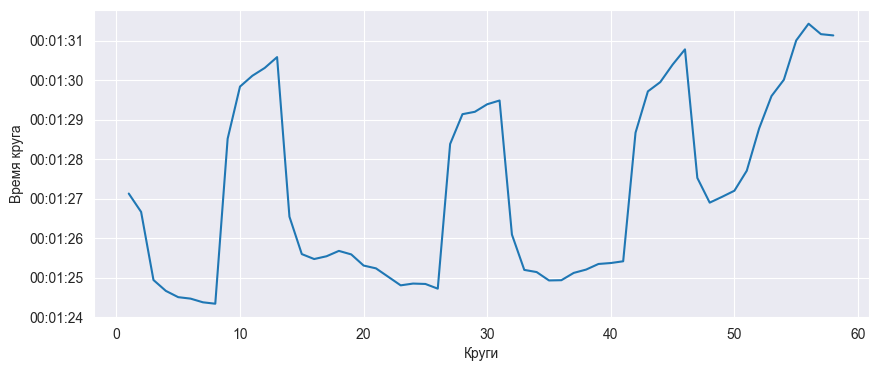

In [42]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,4))
ax = sns.lineplot(x=df17["lap"], y=df17["Скользящее"], data=df17)
ax.set_xlabel('Круги', fontdict={'size': 10})
ax.set_ylabel('Время круга', fontdict={'size': 10})
plt.show()